# 1. Setup

## 1.1 Installing the dependensies

!pip install opencv-python

## 1.2 Importing the dependensies

In [1]:
# Stanadrd dependencies
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# tensorflow dependencies - functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D, Input, Flatten, Dense
import tensorflow as tf

## 1.3. Create Folder structure

In [3]:
#setup paths
POS_PATH = os.path.join('data','positive')
NEG_PATH = os.path.join('data','negative')
ANC_PATH = os.path.join('data','anchor')

#### make directories
#### os.makedirs(POS_PATH)
#### os.makedirs(NEG_PATH)
#### os.makedirs(ANC_PATH)

# 2. Collect positives, negatives and anchors

## 2.1 Collect negatives

In [4]:
# Move the images to the following directory data//negatives
for directory in os.listdir('lfw'):
    directory_path = os.path.join('lfw',directory)
    for file in os.listdir(directory_path):
        EX_PATH = os.path.join('lfw',directory,file)
        NEW_PATH = os.path.join(NEG_PATH,file)
        os.replace(EX_PATH,NEW_PATH)

## 2.2 Collect positives and anchors

In [5]:
#import uuid to generate unique name
import uuid

In [6]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250, 200:200+250, :]

    if cv2.waitKey(1) & 0xFF==ord('a'):
        imgname = os.path.join(ANC_PATH,'{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname,frame)

    if cv2.waitKey(1) & 0xFF==ord('p'):
        imgname = os.path.join(POS_PATH,'{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname,frame)

    
    cv2.imshow("image collection",frame)
    if cv2.waitKey(1) & 0xFF==ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

# 3. Load and Preprocess images

## 3.1 Get image directories

In [7]:
anchor = tf.data.Dataset.list_files(rf'{ANC_PATH}\*.jpg').take(300)
positive = tf.data.Dataset.list_files(rf'{POS_PATH}\*.jpg').take(300)
negative = tf.data.Dataset.list_files(rf'{NEG_PATH}\*.jpg').take(300)

## 3.2 Image Preprocessing - Resize and Scaling

In [8]:
def preprocess(file_path):
    #to read file in string byte
    byte_img = tf.io.read_file(file_path)
    #to decode byte img to tensor
    img = tf.io.decode_jpeg(byte_img)
    #to resize
    img = tf.image.resize(img,(100,100))
    #to rescale
    img = img/255.0
    return img

## 3.3 Create Labelled dataset

In [9]:
[anchor, positive, 1]
[anchor, negative, 0]

[<_TakeDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>,
 <_TakeDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>,
 0]

In [10]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)


In [11]:
print(data)

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>


In [12]:
samples = data.as_numpy_iterator()

In [13]:
example = samples.next()

## 3.4  Build train and test Partition

In [14]:
#used to preprocess all the elements of data
def preprocess_twin(input_img, validate_img, label):
    return (preprocess(input_img), preprocess(validate_img), label)

In [15]:
# build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
#to shuffle the pics so that to create the mix of positives and negatives
data = data.shuffle(buffer_size=1024)

In [16]:
data

<_ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [17]:
# make training set
train_data = data.take(round(len(data)*0.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [18]:
#make validation set
test_data = data.skip(round(len(data)*0.7))
test_data = test_data.take(round(len(data)*0.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Building embedded layer

In [19]:
def make_embedding():
    inp = Input(shape=(100,100,3))
    
    #1st layer
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    #2nd layer
    c2 = Conv2D(120, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    #3rd layer
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    #4th layer
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedded_layer')

In [20]:
embedding =  make_embedding()

In [21]:
embedding.summary()

Model: "embedded_layer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 120)    │       376,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 120)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       245,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,918,968 (148.46 MB)

 Trainable params: 38,918,968 (148.46 MB)

 Non-trainable params: 0 (0.00 B)

## 4.2 Make distance layer

In [22]:
class L1Dist(Layer):
    def __init__(self,**kwargs):
        super().__init__()

    def call(self,input_embedding, validation_embedding):
        return tf.math.abs(input_embedding-validation_embedding)

In [23]:
l1 = L1Dist()

In [24]:
l1

<L1Dist name=l1_dist, built=False>

## 4.3 Make siamese layer

In [25]:
# input_image = Input(name='input_image', shape=(100,100,3))
# validation_image = Input(name='validation_image', shape=(100,100,3))
    
# siamese_layer = L1Dist()
# siamese_layer._name = 'distance'

# input_embedding = embedding(input_image)[0]
# validation_embedding = embedding(validation_image)[0]

# distance = siamese_layer(input_embedding,validation_embedding )

# #final layer of classification
# classifier = Dense(1,activation='sigmoid')(distance)

# siamese_net = Model(inputs=[input_image,validation_image], name='siamese_network', outputs=classifier)


In [26]:
# siamese_net.summary()

In [27]:
def make_siamese_model():
    input_image = Input(name='input_image', shape=(100,100,3))
    validation_image = Input(name='validation_image', shape=(100,100,3))
    
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'

    input_embedding = embedding(input_image)[0]
    validation_embedding = embedding(validation_image)[0]

    distance = siamese_layer(input_embedding,validation_embedding )
    #final layer of classification
    classifier = Dense(1,activation='sigmoid')(distance)

    return Model(inputs=[input_image,validation_image], name='siamese_network', outputs=classifier)


In [28]:
siamese_model = make_siamese_model()

In [29]:
siamese_model.summary()

Model: "siamese_network"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_image    │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedded_layer      │ (None, 4096)      │ 38,918,968 │ input_image[0][0… │
│ (Functional)        │                   │            │ validation_image… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_1 (L1Dist)  │ (None, 4096)      │          0 │ embedded_layer[0… │
│                     │                   │            │ embedded_layer[1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,923,065 (148.48 MB)

 Trainable params: 38,923,065 (148.48 MB)

 Non-trainable params: 0 (0.00 B)

# 5. Training

## 5.1 Setup loss function and optimizer

In [30]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [31]:
opt = tf.keras.optimizers.Adam(1e-4)

## 5.2 Establish Checkpoints

In [32]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3. Build train step function

In [33]:
#this makes graph and make compiling faster
@tf.function
def train_step(batch):
    # records operation 
    with tf.GradientTape() as tape:
        img1, img2, label = batch
        img1 = tf.convert_to_tensor(img1)
        img2 = tf.convert_to_tensor(img2)
        print(img1.shape)
        print(img2.shape)
        #y = batch[2]
        
        #train the model
        yhat = siamese_model([img1, img2], training=True)
        
        #calculates the loss
        loss = binary_cross_loss(label,yhat)
        
    print(loss)
    
    #computes the gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # applies the gradients
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    return loss

## 5.4. Build training loop

In [34]:
def train(data, EPOCHS):
    #loop through each epoch
    for epoch in range(1,EPOCHS+1):
        print('\n epoch {}/{}'.format(epoch,EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

    #loop through each batch
        for idx, batch in enumerate(data):
            train_step(batch)
            progbar.update(idx+1)

    #save checkpoints
        if epoch%10==0:
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5. Train the model

In [35]:
EPOCHS=50

In [36]:
train(train_data, EPOCHS)


 epoch 1/50
(16, 100, 100, 3)
(16, 100, 100, 3)
Tensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)


C:\Users\Avani N. Goswami\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(16, 100, 100, 3))
  warnings.warn(msg)


(16, 100, 100, 3)
(16, 100, 100, 3)
Tensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
4/5 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step (12, 100, 100, 3)
(12, 100, 100, 3)
Tensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)


C:\Users\Avani N. Goswami\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(12, 100, 100, 3))
  warnings.warn(msg)


5/5 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step

 epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step

 epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step

 epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step

 epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step

 epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step

 epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step

 epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step

 epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step

 epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step

 epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step

 epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step

 epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step

 epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step

 epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step

 epoch 16/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step

 epoch 17/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step

 epoch 18/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step

 epoch 19/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step

 epoch 20/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step

 

# 6. Evaluate

In [37]:
from tensorflow.keras.metrics import Recall,Precision

In [91]:
#creating the recall object
p=Precision()
#creating the recall object
m=Recall()

In [104]:
recall=[]
precision=[]

In [204]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [205]:
y_true

array([1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0.],
      dtype=float32)

In [206]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [207]:
y_hat

array([[1.0000000e+00],
       [6.6920130e-08],
       [1.4092114e-09],
       [9.9941802e-01],
       [9.0784136e-09],
       [9.9999994e-01],
       [1.3917579e-09],
       [1.9842419e-07],
       [1.2486277e-07],
       [9.9999964e-01],
       [1.5343451e-07],
       [9.9997532e-01],
       [9.9999934e-01],
       [3.7224777e-09],
       [9.9910176e-01],
       [9.4693919e-10]], dtype=float32)

In [208]:
[1 if prediction>0.5 else 0 for prediction in y_hat]

[1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0]

In [209]:


#calculating the recall value
m.update_state(y_true,y_hat)



#return recall result
re = m.result().numpy()
recall.append(re)

In [210]:

#calculating the recall value
p.update_state(y_true,y_hat)


#return recall result
pre = p.result().numpy()
precision.append(pre)


In [211]:
print(sum(recall))

12.0


In [212]:
sum(recall)/len(recall)

1.0

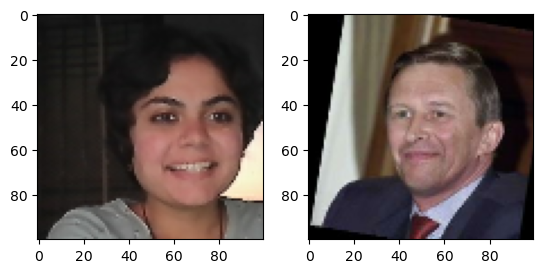

In [216]:

plt.subplot(1,2,1)
plt.imshow(test_input[1])
plt.subplot(1,2,2)
plt.imshow(test_val[1])
plt.show()